# Extracting temperature data using GBR features
**Author**: Denisse Fierro Arcos  
  
This notebook will demonstrate how to use one or more Great Barrier Reef (GBR) features recognised by the Great Barrier Reef Marine Park Authority (GBRMPA) dataset to extract water temperature data from the AIMS Sea Surface Temperature Monitoring Program available at RIMReP `geoparquet` collection.

In addition to published `Python` libraries, this notebook uses a set of functions especially created for manipulating RIMReP data collections. These functions are available in the `useful_spatial_functions_data_extraction.py` script, which **must** exist in the same directory where this notebook is located.

## Loading libraries

In [2]:
# Loading custom library
import useful_spatial_functions_data_extraction as usf
# Data manipulation - regular expression (regex)
import re
# Load and manipulate geospatial data
import dask_geopandas
import geopandas as gpd
# Plotting
import matplotlib.pyplot as plt
# Mapping
import cartopy.crs as ccrs
# Interact with operating system
import os

## Loading GBR features of interest
In this section, we will use the functions included in the [useful_spatial_functions_data_extraction](https://github.com/aodn/rimrep-examples/blob/main/Python_based_scripts/useful_spatial_functions_data_extraction.py) script to load GBR features of interest. We will then use the boundaries of the feature of interest to identify the names of the sites within these limits.

We will use the `gbr_features` function to access the boundaries for our sites of interest. If no parameters are given to this function, it will load all features recognised by GBRMPA. You could also provide the name of the site using the `site_name` parameter or the GBRMPA unique ID using the `site_id` parameter. You can also use both parameters at the same time in case you have the names for some sites and the IDs for others.

As an example, we will use **U/N Reef** or unnamed reefs. It should be noted that **U/N Reef** refers to multiple unnamed reefs, and each reef can be identified by its `UNIQUE_ID`. We chose to use **U/N Reef** for this example simply because it will return multiple reefs within the GBR and thus will overlap with the most number of AIMS monitoring sites.

In [3]:
#Getting features using custom library
un_reefs = usf.gbr_features(site_name = 'u/n reef')

#Checking results
un_reefs

Subsetting GBR features by u/n reef


,UNIQUE_ID,GBR_NAME,LOC_NAME_S,geometry
fid,,,,
459,09361104104,U/N Reef,U/N Reef (09-361d),"POLYGON ((143.22825 -9.26410, 143.22802 -9.264..."
460,09361104100,U/N Reef,U/N Reef (09-361),"POLYGON ((143.23613 -9.26759, 143.23502 -9.267..."
461,09361104102,U/N Reef,U/N Reef (09-361b),"POLYGON ((143.23517 -9.26074, 143.23577 -9.261..."
462,09361104103,U/N Reef,U/N Reef (09-361c),"POLYGON ((143.22800 -9.26056, 143.22740 -9.260..."
463,09361104105,U/N Reef,U/N Reef (09-361e),"POLYGON ((143.21933 -9.25797, 143.21873 -9.257..."
...,...,...,...,...
9594,10521109102,U/N Reef,U/N Reef (10-521b),"POLYGON ((142.40691 -10.70788, 142.40684 -10.7..."
9596,10521109101,U/N Reef,U/N Reef (10-521a),"POLYGON ((142.40495 -10.72571, 142.40476 -10.7..."
9597,10523109101,U/N Reef,U/N Reef (10-523a),"POLYGON ((142.41640 -10.72591, 142.41605 -10.7..."


We will now extract data only for the monitoring sites located within the GBR feature of our interest. To reduce time of computation, we will apply an initial filter to the dataset with the maximum extent of our polygon of interest (`un_reef`). Once the AIMS data is pre-filtered and loaded into memory, we will then apply the polygon of interest to extract only the data for the sites within the polygon.

In [32]:
# We get a bounding box around the sites of interest to apply an initial filter to the AIMS dataset
minx = un_reefs.bounds.minx.min()
miny = un_reefs.bounds.miny.min()
maxx = un_reefs.bounds.maxx.max()
maxy = un_reefs.bounds.maxy.max()

# Creating maximum and minimum coordinates for bounding box around our area of interest
filter = [('lon', '>=', minx),
          ('lat', '>=', miny),
          ('lon', '<=', maxx),
          ('lat', '<=', maxy),
          #We will add another condition to our filter. We will only keep data with quality control flag 1
          ('qc_flag', '=', 1)]

#Checking filter
filter

[('lon', '>=', 141.12840666709278),
 ('lat', '>=', -24.43006550562101),
 ('lon', '<=', 153.16768375833198),
 ('lat', '<=', -8.965183578334386),
 ('qc_flag', '=', 1)]

## Connecting to RIMReP data collection
Connecting to the AIMS Sea Surface Temperature Monitoring Program dataset, and loading unique sampling site for the AIMS program. We will only load three columns that are relevant to this exercise: `site` (name of deployment site), `subsite` (name of deployment site and code identifying deployment location) and `geometry` (latitude and longitude coordinates).    
  
For more information about the AIMS Sea Surface Temperature Monitoring Program dataset, visit the [AIMS website](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e). You can also refer to this [Jupyter notebook](https://github.com/aodn/rimrep-examples/blob/main/Python_based_scripts/Extracting_Water_Temperature_at_Site.ipynb).  
  
Connecting to S3 database and loading results can take a few minutes as the database contains over 150 million records. To speed up this process, we will apply an initial filter to the original dataset with the maximum extent of our polygon of interest (`un_reef`). Once the AIMS data is pre-filtered and loaded into memory, we will then apply the polygon of interest to extract only the data for the sites within the polygon.

In [15]:
# Connecting to the S3 bucket where the AIMS temperature data is stored
dask_geo_df = dask_geopandas.read_parquet("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                                          #Applying initial bounding box filter
                                          filters = [filter], 
                                          #Specifying which columns to read
                                          columns = ['site', 'subsite', 'geometry'],
                                          #Specifying the column to be used as index
                                          index = 'fid',
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True}) 

# Keeping unique values
dask_geo_df = dask_geo_df.drop_duplicates()

# Transforming to pandas dataframe
sites = dask_geo_df.compute()

print(f'There are {len(sites)} unique sites in the AIMS dataset')
# Checking the contents of the dataframe - First five rows
sites.head()

There are 408 unique sites in the AIMS dataset


,site,subsite,geometry
fid,,,
149519190,Night Island,NIGFL1,POINT (143.58030 -13.16910)
149501081,Night Island,NIGSL1,POINT (143.58030 -13.16900)
53983161,Curd Reef,CURDFL1,POINT (143.51120 -12.58530)
120049696,Curd Reef,CURDSL1,POINT (143.51120 -12.58470)
146426455,Weipa(lorim point),WEISL1,POINT (141.86650 -12.67090)


### Identifying sites of interest
Depending on the amount of polygons used to identify the sites of interest, this may take a couple of minutes. Before we can identify the sites of interest, we must ensure both `geopandas` data frames are in the same coordinate reference system (CRS).

We will plot the original AIMS monitoring sites (black), the polygon of interest (red) and the sites within polygons (blue) to check that sites have been correctly identified.

Note that unless the AIMS site is within a polygon, it will not to be identified in our final list.

In [16]:
#Ensuring CRS are the same in both dataframes
if sites.crs != un_reefs.crs:
    sites = sites.set_crs(un_reefs.crs)

# Clippping original_data with area_polygons
sites_temp = gpd.sjoin(sites, un_reefs, how = 'inner')

print(f'There are {len(sites_temp)} unique sites within the area of interest.')
#Checking results - First five rows
sites_temp.head()


There are 35 unique sites within the area of interest.


,site,subsite,geometry,index_right,UNIQUE_ID,GBR_NAME,LOC_NAME_S
fid,,,,,,,
24885915,Yorke Island,YORKSL3,POINT (143.39850 -9.75790),934,09409104102,U/N Reef,U/N Reef (09-409b)
117798096,Yorke,YORKESL1,POINT (143.39840 -9.76050),934,09409104102,U/N Reef,U/N Reef (09-409b)
49498008,Yorke,YORKEFL1,POINT (143.39870 -9.76040),934,09409104102,U/N Reef,U/N Reef (09-409b)
19125316,Yorke Island,YORKSL6,POINT (143.40130 -9.76080),934,09409104102,U/N Reef,U/N Reef (09-409b)
48698538,Mabuiag Island,MABUIAGFL1,POINT (142.20460 -9.95060),2442,09255104104,U/N Reef,U/N Reef (09-255d)


### Plotting all AIMS sites and sites of interest in a single map 

<GeoAxes: >

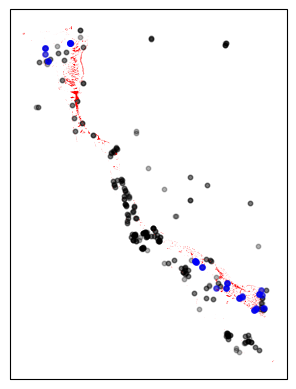

In [17]:
#Initiliasing the figure
fig = plt.figure()

#Adding a plot to the figure and assigning projection
ax = plt.axes(projection = ccrs.PlateCarree())

#Plotting all AIMS monitoring sites in black
sites.plot(ax = ax, alpha = 0.3, color = 'black', markersize = 10)
#Plotting GBR polygons matching our criteria in pink (U/N reefs)
un_reefs.plot(ax = ax, color = 'red')
#Plotting AIMS monitoring sites within our area of interest in blue
sites_temp.plot(ax = ax, alpha = 0.5, color = 'blue', markersize = 15)


### Extracting temperature for monitoring site within area of interest
We will now extract data only for the monitoring sites located within the GBR feature of our interest. We will apply the initial filter that matches our polygon of interest (`un_reef`). Once the AIMS data is pre-filtered and loaded into memory, we will then apply the polygon of interest to extract only the data for the sites within the polygon.

In [34]:
# Connecting to the S3 bucket where the AIMS temperature data is stored
dask_geo_df = dask_geopandas.read_parquet("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                                          #Applying initial bounding box filter
                                          filters = [filter], 
                                          #Specifying which columns to read
                                          columns = ['site', 'subsite', 'time', 'qc_val', 'geometry'],
                                          #Specifying the column to be used as index
                                          index = 'fid',
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True}) 

From the `geopandas` dataframe with the sites overlapping our polygon of interest, we will get a list of unique sites and apply this as a second filter. This may take a couple of minutes to run.

In [50]:
# Getting list of subsites within our area of interest
sites_int = sites_temp.subsite.unique().tolist()

# Keeping only data from sites within our area of interest
dask_geo_df = dask_geo_df[dask_geo_df.subsite.isin(sites_int)]

# Transforming to pandas dataframe
temp_data = dask_geo_df.compute()

# Checking results - First five rows
temp_data.head()

,site,subsite,time,qc_val,geometry
fid,,,,,
24885915,Yorke Island,YORKSL3,2010-05-04 13:54:31+00:00,28.9556,POINT (143.39850 -9.75790)
24885914,Yorke Island,YORKSL3,2010-05-04 13:44:31+00:00,28.9356,POINT (143.39850 -9.75790)
24858725,Yorke Island,YORKSL3,2010-04-23 14:54:31+00:00,29.3067,POINT (143.39850 -9.75790)
24623645,Yorke Island,YORKSL3,2010-01-24 18:24:31+00:00,28.6748,POINT (143.39850 -9.75790)
24623644,Yorke Island,YORKSL3,2010-01-24 18:14:31+00:00,28.6748,POINT (143.39850 -9.75790)


## Creating `deployment_location` column
We will use the `subsite` column to create the deployment categories as explained in the section above. If no condition is met, then we will label the row as other.  
  
Due to the amount of data contained in this data frame, this may take a few minutes to run.

In [51]:
# Creating new column with deployment location information
temp_data['deployment_location'] = temp_data.apply(lambda x: 'reef slope' if bool(re.match('.*(SL[0-9]{1,2})', x.subsite)) == True \
         else ('reef flat' if bool(re.match('.*(FL[0-9]{1,2})', x.subsite)) == True else 'other'), axis = 1)

# Checking results - First five rows
temp_data

,site,subsite,time,qc_val,geometry,deployment_location
fid,,,,,,
24885915,Yorke Island,YORKSL3,2010-05-04 13:54:31+00:00,28.9556,POINT (143.39850 -9.75790),reef slope
24885914,Yorke Island,YORKSL3,2010-05-04 13:44:31+00:00,28.9356,POINT (143.39850 -9.75790),reef slope
24858725,Yorke Island,YORKSL3,2010-04-23 14:54:31+00:00,29.3067,POINT (143.39850 -9.75790),reef slope
24623645,Yorke Island,YORKSL3,2010-01-24 18:24:31+00:00,28.6748,POINT (143.39850 -9.75790),reef slope
24623644,Yorke Island,YORKSL3,2010-01-24 18:14:31+00:00,28.6748,POINT (143.39850 -9.75790),reef slope
...,...,...,...,...,...,...
37640512,20-104 Reef,20104FL1,2015-01-31 17:20:00+00:00,28.8240,POINT (149.69330 -20.02860),reef flat
37640513,20-104 Reef,20104FL1,2015-01-31 17:30:00+00:00,28.8240,POINT (149.69330 -20.02860),reef flat
37640511,20-104 Reef,20104FL1,2015-01-31 17:10:00+00:00,28.7940,POINT (149.69330 -20.02860),reef flat


## Calculating mean monthly temperatures for each deployment location
This calculation will only include the sites within the polygon of interest. We will need to add a couple of extra columns: `year` and `month` before we can calculate monthly means and plot time series.

In [89]:
# Adding year and month columns for data grouping
temp_data['year'] = temp_data.time.dt.year
temp_data['month'] = temp_data.time.dt.month
temp_data['month'] = temp_data.month.apply(lambda x: str(x).zfill(2))

# Creating dates column by uniting year and month columns
temp_data['dates'] = temp_data.year.astype(str) + '-' + temp_data.month

Now we can group data by the new `dates` column and calculate the mean temperature for each month. 

In [91]:
# Calculating monthly means
mean_temp_dep = temp_data.groupby(['dates', 'deployment_location']).mean('qc_val').round(2).reset_index()

# Checking results - First five rows
mean_temp_dep.head()

,dates,deployment_location,qc_val,year
0,1995-11,reef flat,26.19,1995.0
1,1995-11,reef slope,26.14,1995.0
2,1995-12,reef flat,26.79,1995.0
3,1995-12,reef slope,26.83,1995.0
4,1996-01,reef flat,27.26,1996.0


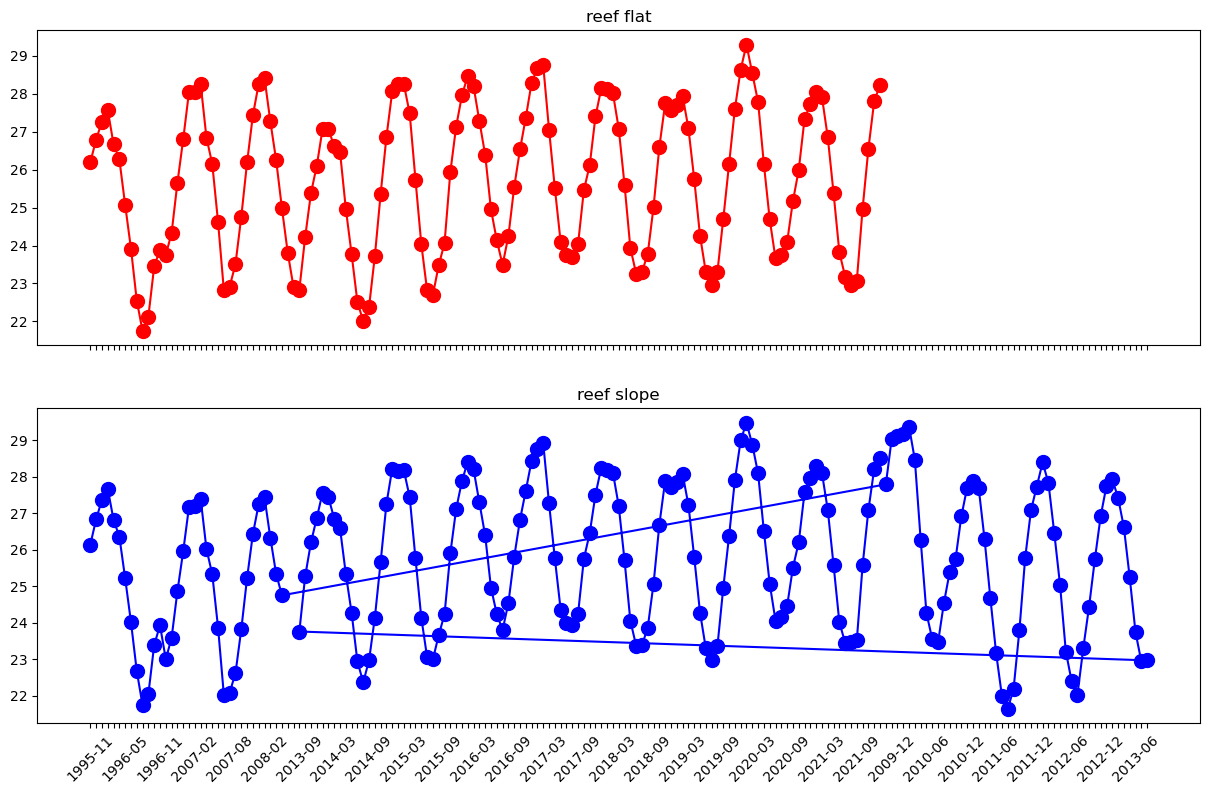

In [104]:
# We initialise the figure and axes. We also define the size of the figure.
# Axes refer to the subplots in the figure (2 rows and 1 column). They will share the x axis
fig, ax = plt.subplots(2, 1, figsize = (15, 9), sharex = True)

# We group our data by site, colours, and deployment location
groups = mean_temp_dep.groupby('deployment_location')

# Now we use our groups to plot the data
# Element here has the categories of the groupby object (deployment location)
# Group has the subset dataframes for each category
for element, group in groups:
    # If the deployment location is reef flat, we plot the data in the first subplot
    if 'flat' in element:
         # Plotting dates in x axis and mean temperature in y axis
        ax[0].plot(group['dates'], group['qc_val'], marker = 'o', ms = 10, 
             # We use the site name as the label for each line and the color will change based on the colour column
             label = f'{element}', color = 'red')
        # Title for subplot
        ax[0].set_title(f'{element}')
    # In all other cases, we plot the data in the second subplot
    else:
        #As above
        ax[1].plot(group['dates'], group['qc_val'], marker = 'o', ms = 10, 
             label = f'{element}', color = 'blue')
        ax[1].set_title(f'{element}')

# Getting all labels from x axis
axis_labs = ax[1].xaxis.get_ticklabels()
# Removing all labels from x axis
[l.set_visible(False) for l in axis_labs]
# Making every 6th label visible and rotating it 45 degrees
for label in axis_labs[::6]:
    label.set_visible(True)
    label.set_rotation(45)

If you would like to save the figure, you can use the `savefig` method, as follows: `plt.savefig(file_name)`. Here `file_name` can contain a path to a directory and a file name with the extension of the file type you would like to save the figure as. For example, `plt.savefig('figures/temperature_timeseries.png')` will save the figure in a directory called `figures` and the file name will be `temperature_timeseries.png`.  

## Saving data summaries

In [19]:
# Ensuring output folder exists. If not, create folder
os.makedirs('Outputs', exist_ok = True)

# Saving summary table to csv - Not saving row indices
mean_temp_dep.to_csv('Outputs/mean_temp_dep.csv', index = False)